# Data Analysis

## Data Extraction from Database for Analysis

Now that the data has been collected, processed, and cleaned, I then conducted exploratory data analysis to find trends, or an explanation to my original question, which was:
- Why is the U.S. consistently less happy than the happiest countries, and can economic indicators help explain this gap?

I was motivated by the fact that despite its wealth, the U.S. ranks lower in the World Happiness Report than many smaller European nations. I wanted to go beyond GDP and dig into structural factors like trust in government, corruption, and institutional effectiveness.  

So I decided to:
- Pull in happiness data from the World Happiness Report
- Merge it with World Bank economic and governance indicators
- Compare the U.S. to the **top 5 happiest countries** from the 2024 report
- Analyze which indicators correlate most strongly with national happiness

First I queried the data from my database that comprises of two tables, so that I had the columns and data to use for my analysis:
- World_Bank_Data
- Happiness_Index_Data

In [139]:
# Importing the necessary imports and packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install openpyxl
import sys
sys.path.append('/files/me204-2025-project-jayden/scripts')
from utils import load_joined_world_bank_happiness

I made a function that connects to the database and pulls the whole joined dataset from it.
I also used this function below for an the interactive graph that I placed in the index.qmd file, which is why I made a function in utils.py, so it reduces repetition

In [140]:
# Imported and used my function that connects to the database and pulls the whole joined dataset from iter
# I used this in analysis, so it reduces repetition
db_path = "/files/me204-2025-project-jayden/data/database.db"
df = load_joined_world_bank_happiness(db_path)
df.head()

,Rank,Country,Year,GDP_Current_USD,Health_Expenditure_percent_GDP,Education_Expenditure_percent_GDP,Unemployment_Rate_percent,Inflation_Annual_percent,FDI_Net_Inflows_percent_GDP,Population_Total,...,Rule_of_Law,Control_of_Corruption,Political_Stability,Voice_and_Accountability,GDP_Per_Capita,Happiness_Score,Social_support,Freedom_to_make_life_choices,Generosity,Perceptions_of_corruption
0,3,Denmark,2018,355293374912,10.10,7.30,5.13,0.81,2.47,5793636,...,1.77,2.16,0.93,1.57,61324.77,7.56,1.59,0.68,0.28,0.41
1,2,Denmark,2019,345401473013,10.15,7.26,5.02,0.76,-1.10,5814422,...,1.83,2.12,0.97,1.54,59404.27,7.60,1.57,0.59,0.25,0.41
2,2,Denmark,2020,355631021932,10.72,7.38,5.64,0.42,0.36,5831404,...,1.81,2.24,0.92,1.51,60985.49,7.65,0.96,0.95,0.07,0.17
3,2,Denmark,2021,408378204640,10.75,7.00,5.04,1.85,4.16,5856733,...,1.90,2.33,0.93,1.54,69727.99,7.62,0.95,0.95,0.03,0.18
4,2,Denmark,2022,401945576108,9.48,5.30,4.43,7.70,7.67,5903037,...,1.90,2.40,0.87,1.59,68091.32,7.64,1.24,0.72,0.19,0.53


To explore this, I looked beyond just income and GDP. In the sections that follow, I analyze deeper indicators like Rule of Law, institutional trust, and governance quality, using World Bank data to better understand what separates the happiest nations from the rest

## Exploratory Data Analysis

In [141]:
# Selected the top happiest countries and the US for comparison
countries_to_plot = ["Finland", "Denmark", "Iceland", "Sweden", "Netherlands", "United States"]
# Filtered the data to only include the countries I wanted to analyze
line_df = df[df["Country"].isin(countries_to_plot)]

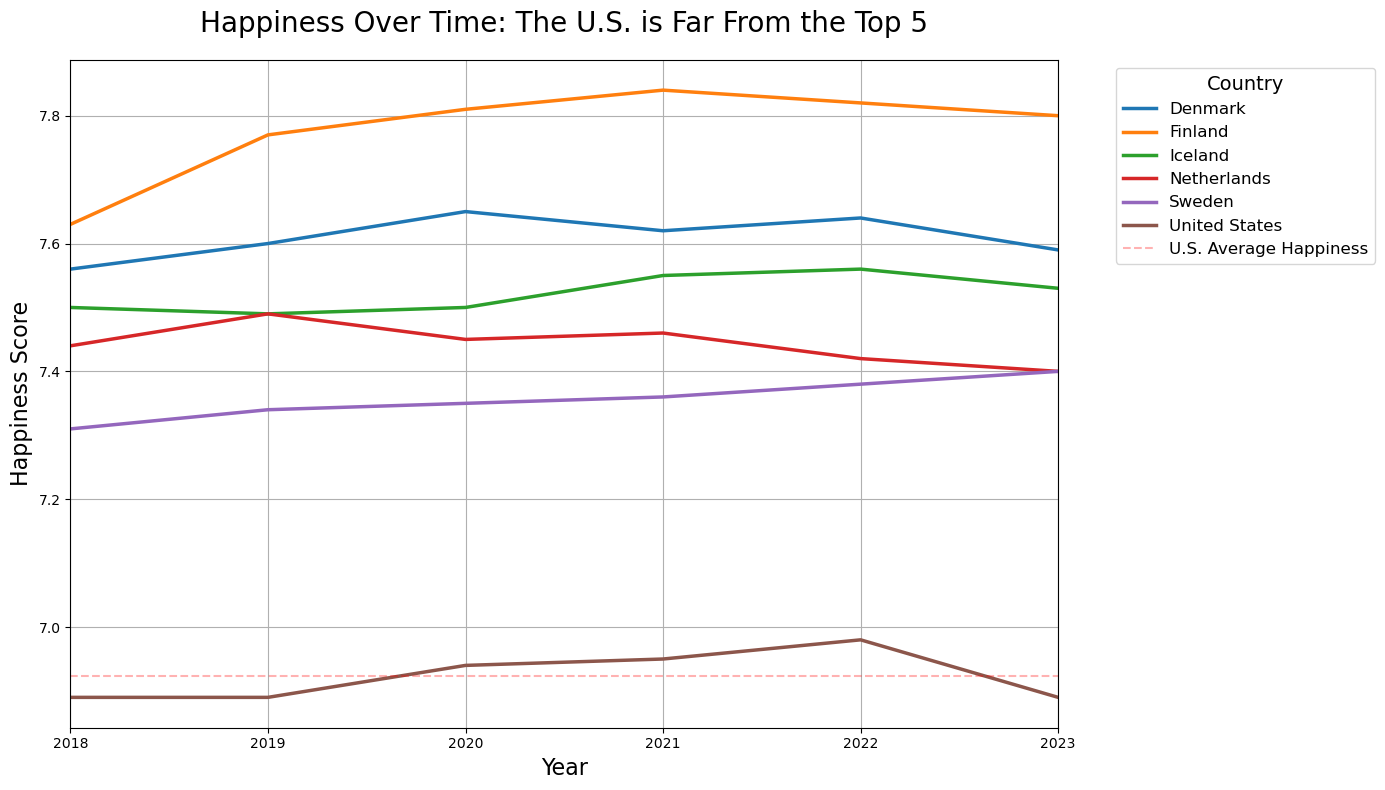

In [142]:
# Set up the plot with a larger figure size to accommodate the external legend
plt.figure(figsize=(14, 8))

# Created line plots for each country showing happiness trends over time
sns.lineplot(data=line_df, x="Year", y="Happiness_Score", hue="Country", linewidth=2.5)

# Added a horizontal dashed line to highlight the US average happiness for comparison
plt.axhline(y=line_df[line_df["Country"] == "United States"]["Happiness_Score"].mean(),
            linestyle="--", color="red", alpha=0.3, label="U.S. Average Happiness")
# Set the title and axis labels with increased font sizes for better readability
plt.title("Happiness Over Time: The U.S. is Far From the Top 5", fontsize=20, pad=20)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Happiness Score", fontsize=16)
# Positioned the legend outside the plot area on the right side to avoid overlapping data
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
# Set the x-axis limits to show only the years from 2018 to 2023
plt.xlim(2018, 2023)
# Added grid for easier reading of values
plt.grid(True)
# Applied tight layout to ensure everything fits properly with the external legend
plt.tight_layout()
plt.savefig("/files/me204-2025-project-jayden/docs/figures/happiness_over_time.svg", format="svg", bbox_inches='tight')
plt.show()


To begin, I visualized the Happiness Scores of the top 5 happiest countries in the 2024 World Happiness Report, which were Finland, Denmark, Iceland, Sweden, and the Netherlands, alongside the United States, spanning from 2018 to 2023.

The results show that the top 5 happiest countries have consistently maintained high levels of happiness (above 7 on average), the U.S. lags noticeably behind, with more fluctuation and an average hovering closer to 6.8. This persistent gap raises an important question:

Why is the U.S. consistently less happy than the happiest countries, and can economic indicators help explain this gap?

To understand which factors matter most, I calculated correlations between happiness and every indicator to happiness to see any possible trends that arise. I wanted to see which factors most closely related/correlatd with happiness, which could help explain what the U.S. needs to focus on.

Note*: I excluded population total in all analysis below, because that doesn't seem to be a social, government, or economic indicator, and doesn't really seem like it would matter in regards to any sort of happiness problems, since all countries in ths dataset are at healthy populations.

In [143]:
# Drop 'Year', 'Population_Total', and 'Rank' before correlation because they are uneeded
# and surely do not matter when comparing happiness with indicators
filtered_for_correlations = df.drop(columns=["Year", "Rank", "Population_Total"])

# Computed correlations for every indicator needed
correlations = filtered_for_correlations.corr(numeric_only=True)["Happiness_Score"].drop("Happiness_Score").sort_values(ascending=False)

# Created the correlation table
corr_table = pd.DataFrame({
    "Indicator": correlations.index,
    "Correlation with Happiness Score": correlations.values
}).reset_index(drop=True)

# Rounded the numbers by 3
corr_table["Correlation with Happiness Score"] = corr_table["Correlation with Happiness Score"].round(3)
# Styled the dataset using pandas styler
corr_table.style.background_gradient(cmap="coolwarm", subset=["Correlation with Happiness Score"])
corr_table

,Indicator,Correlation with Happiness Score
0,Rule_of_Law,0.930
1,Voice_and_Accountability,0.866
2,Control_of_Corruption,0.828
3,Govt_Effectiveness,0.772
4,Political_Stability,0.702
5,Life_Expectancy_Years,0.684
6,Education_Expenditure_percent_GDP,0.386
7,Freedom_to_make_life_choices,0.322
8,Unemployment_Rate_percent,0.241
9,Social_support,0.037


There are many insights that can be derived from the table, but to easier see this, and visualize the differences, I plotted it below on a diverging bar chart:

/tmp/ipykernel_417/927741192.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




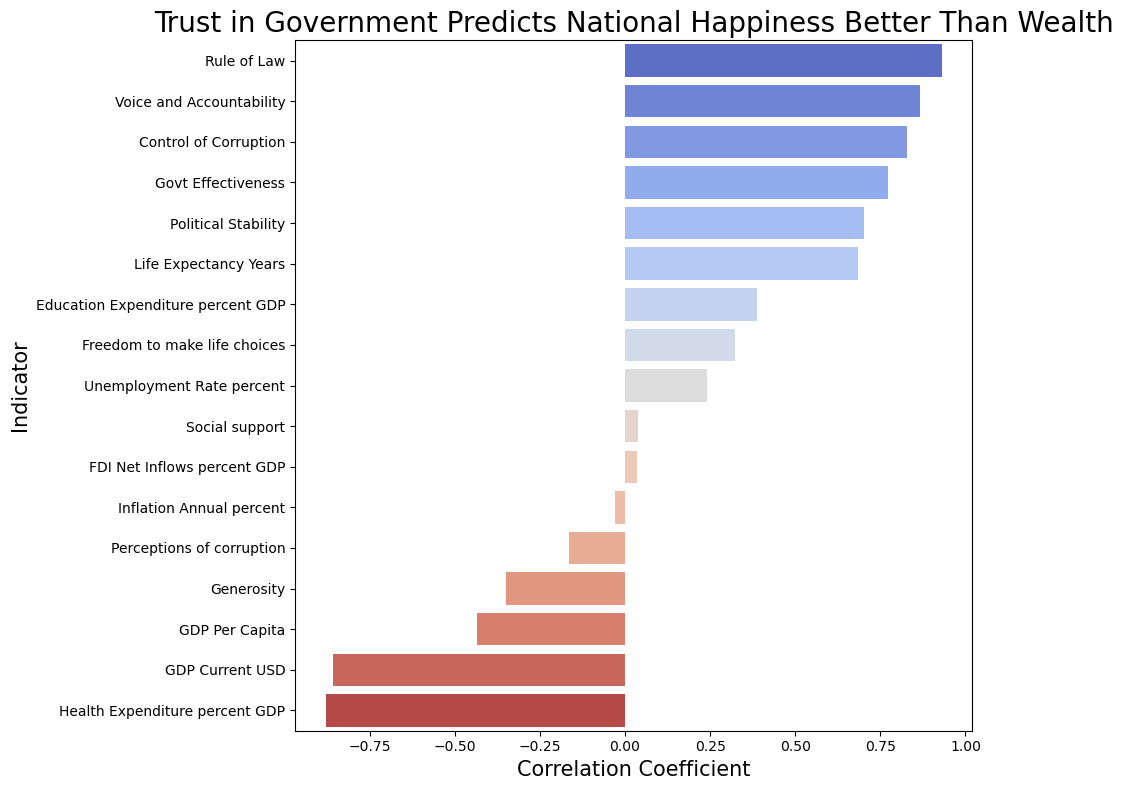

In [144]:
# Plotted this correlation data, to better vizualize the trends
plt.figure(figsize=(10, 8))

# Converted correlations Series to DataFrame so seaborn could properly label axes
corr_df = correlations.reset_index()
corr_df.columns = ['Indicator', 'Correlation']
# Replaced underscores with spaces in indicator names for better readability
corr_df['Indicator'] = corr_df['Indicator'].str.replace('_', ' ')

# Used the DataFrame approach so seaborn knew what to label the axes
sns.barplot(data=corr_df, x='Correlation', y='Indicator', palette="coolwarm")

# Title and plot
plt.title("Trust in Government Predicts National Happiness Better Than Wealth", fontsize=20)
plt.xlabel("Correlation Coefficient", fontsize=15)
plt.ylabel("Indicator", fontsize=15)
plt.tight_layout()
# Saved the plot
plt.savefig("/files/me204-2025-project-jayden/docs/figures/correlation_with_happiness.svg", format="svg", bbox_inches='tight')
plt.show()

A correlation coefficient ranges from -1 to +1. Values above 0.75 are considered strong, meaning the variables move closely together. So the governance indicators with coefficients above 0.75 show a reliably strong link to happiness

One of the most surprising findings was that Health Expenditure (% of GDP) had a strong negative correlation with happiness. This metric shows how much of a country’s economy goes toward healthcare overall (doctors, hospitals, insurance, etc.), and in some cases, like the U.S., high spending doesn’t correlate to better access or quality.

The strongest correlating factors with happiness were Rule of Law (0.93), Voice and Accountability (0.87), and Control of Corruption (0.83). That tells us people are happier in countries where laws are fair, leaders are accountable, and corruption is low. Government Effectiveness (0.77), Political Stability (0.70), and Life Expectancy (0.68) also had strong positive relationships. The governments stability and health clearly matter.

GDP (current USD) and Population had strong negative correlations (both around -0.86), suggesting that being a large or rich country doesn’t automatically mean happier citizens. Even Generosity (-0.35) and Perceptions of Corruption (-0.16) were barely and negatively correlated.

Overall, happiness seems tied less to how much a country spends or how big it is, and more to whether people feel safe, heard, politically stable, and fairly treated.

I also made a plot to visualize this correlation graph by country to see which variables most explain happiness, and to see where the U.S. falls compared to other countries. This is an interactive plot that I also included in my index.qmd, so I had to import it into an html to keep its interactivity in the Quarto markdown file

In [145]:
# Generated an interactive scatter plot comparing Happiness Score to various World Bank indicators
# Included a dropdown menu to allow users to switch the x-axis variable dynamically

# Imported and used my function that connects to the database and pulls the whole joined dataset from it
# I used this in analysis, so it reduces repetition
db_path = "/files/me204-2025-project-jayden/data/database.db"
df = load_joined_world_bank_happiness(db_path)

# Averaged across years to produce a single row per country.
df = df.groupby("Country", as_index=False).mean(numeric_only=True)

I used the function that I used earlier to query the database. This was placed in utils.py. I did this to reduce redundancy, so that I could use it multiple times without have to rewrite/paste the code again in the same notebook

I then made the necessary variables for the plot.

In [146]:
# Selected numeric columns to use as x-axis options
# Excluded variables that were either redundant or not meaningful for comparison for the y axis
# Since i used happiness in the y axis, i excluded it here
exclude = ["Rank", "Year", "Population_Total", "Happiness_Score"]
x_vars = [col for col in df.select_dtypes("number").columns if col not in exclude]

# Fixed the y-axis to Happiness Score, which remained constant across views
y = "Happiness_Score"
x0 = x_vars[0]  
# Chose the first variable as the default x-axis

# Created the scatter plot figure using Plotly
fig = go.Figure()

In [147]:
# Added a trace that plotted each country as a labeled dot
# Used 'markers+text' mode to display country names above each point
fig.add_trace(go.Scatter(
    x=df[x0],
    y=df[y],
    mode="markers+text",
    text=df["Country"],
    textposition="top center",
    marker=dict(size=10, color="mediumseagreen"),
    name=f"{x0} vs {y}"
))

# Updated the layout to improve readability and fit within the page.
fig.update_layout(
    title="Governance, Not Money: See What Correlates Most with Happiness",
    autosize=True,
    width=900,
    height=600,
    margin=dict(t=100, l=100, r=80, b=100),

    # Changed the camel case formatting
    xaxis=dict(
        title=dict(text=x0.replace("_", " "), standoff=20),
        automargin=True
    ),

    # Made the formatting strong for the y axis label
    yaxis=dict(
        title=dict(text="Happiness Score", standoff=20),
        # Increased standoff for breathing room
        automargin=True
         # Moved tick labels outside the axis line
    ),

    # Added a dropdown menu that allowed users to switch the x-axis variable.
    updatemenus=[{
        "buttons": [
            {
                "method": "update",
                # Used 'update' to modify existing trace and axis layout
                # Each button updated both the x-values and the axis title to reflect the selected indicator
                "label": x.replace("_", " "),
                "args": [
                    {"x": [df[x]]},
                    {"xaxis": {"title": dict(text=x.replace("_", " "), standoff=20)}}
                ]
            } for x in x_vars
            # Used a list comprehension to interactively generate buttons for columns
        ],
        "direction": "down",
        # Chose dropdown style for compactness and clarity
        "showactive": True,
        # Highlighted the active selection for user feedback
        "x": 0.98,
        "y": 1.15,
        "xanchor": "right",
        "yanchor": "top",
        "pad": {"r": 10, "t": 10}
        # Added padding to prevent overlap with chart elements
    }]
)

# Rendered the chart in the Quarto page.
# Made sure to import it into an html so i can include it in the quarto markdown file
fig.write_html("../docs/interactive_happiness_scatter.html")
fig.show()

You can see how consistently governance metrics show the most correlation to happiness than economic ones. Besides government factors, even indicators like Freedom to make life choices and Social support showed stronger patterns than GDP. It made me rethink what development actually means, and how we measure success and happiness.

Since governance indicators showed the strongest link to happiness, I focused on four key ones to see how the U.S. compares to the happiest nations:
- Rule of Law
- Control of Corruption
- Government Effectiveness
- Political Stability

I chose four specifically because the [National Library of Medicine](https://pmc.ncbi.nlm.nih.gov/articles/PMC4913118/) states that a correlation coefficient above 0.75 constitutes as good or excellent reliability. Those 4 variable are the only ones above 0.75 correlation coeffiecient

In [148]:
# Dropped all the rows that I am not using, that have low correlations
df_clean = df.dropna(subset=[
    "Happiness_Score", 
    "GDP_Per_Capita", 
    "Rule_of_Law", 
    "Control_of_Corruption", 
    "Govt_Effectiveness", 
    "Political_Stability"
])

# Grouped by countries, and took the average from all the years collected so it
# takes into account data throughout the years, and not just the most previous year
df_avg = df_clean.groupby("Country", as_index=False).mean(numeric_only=True)

# These are the economic indicators with the highest positive correlations to loop through
indicators = [
    "Rule_of_Law", 
    "Control_of_Corruption", 
    "Govt_Effectiveness", 
    "Political_Stability"
]

Now that I dropped all of the columns except the top 4, I could proceed making the vizualization


/tmp/ipykernel_417/4269433080.py:89: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



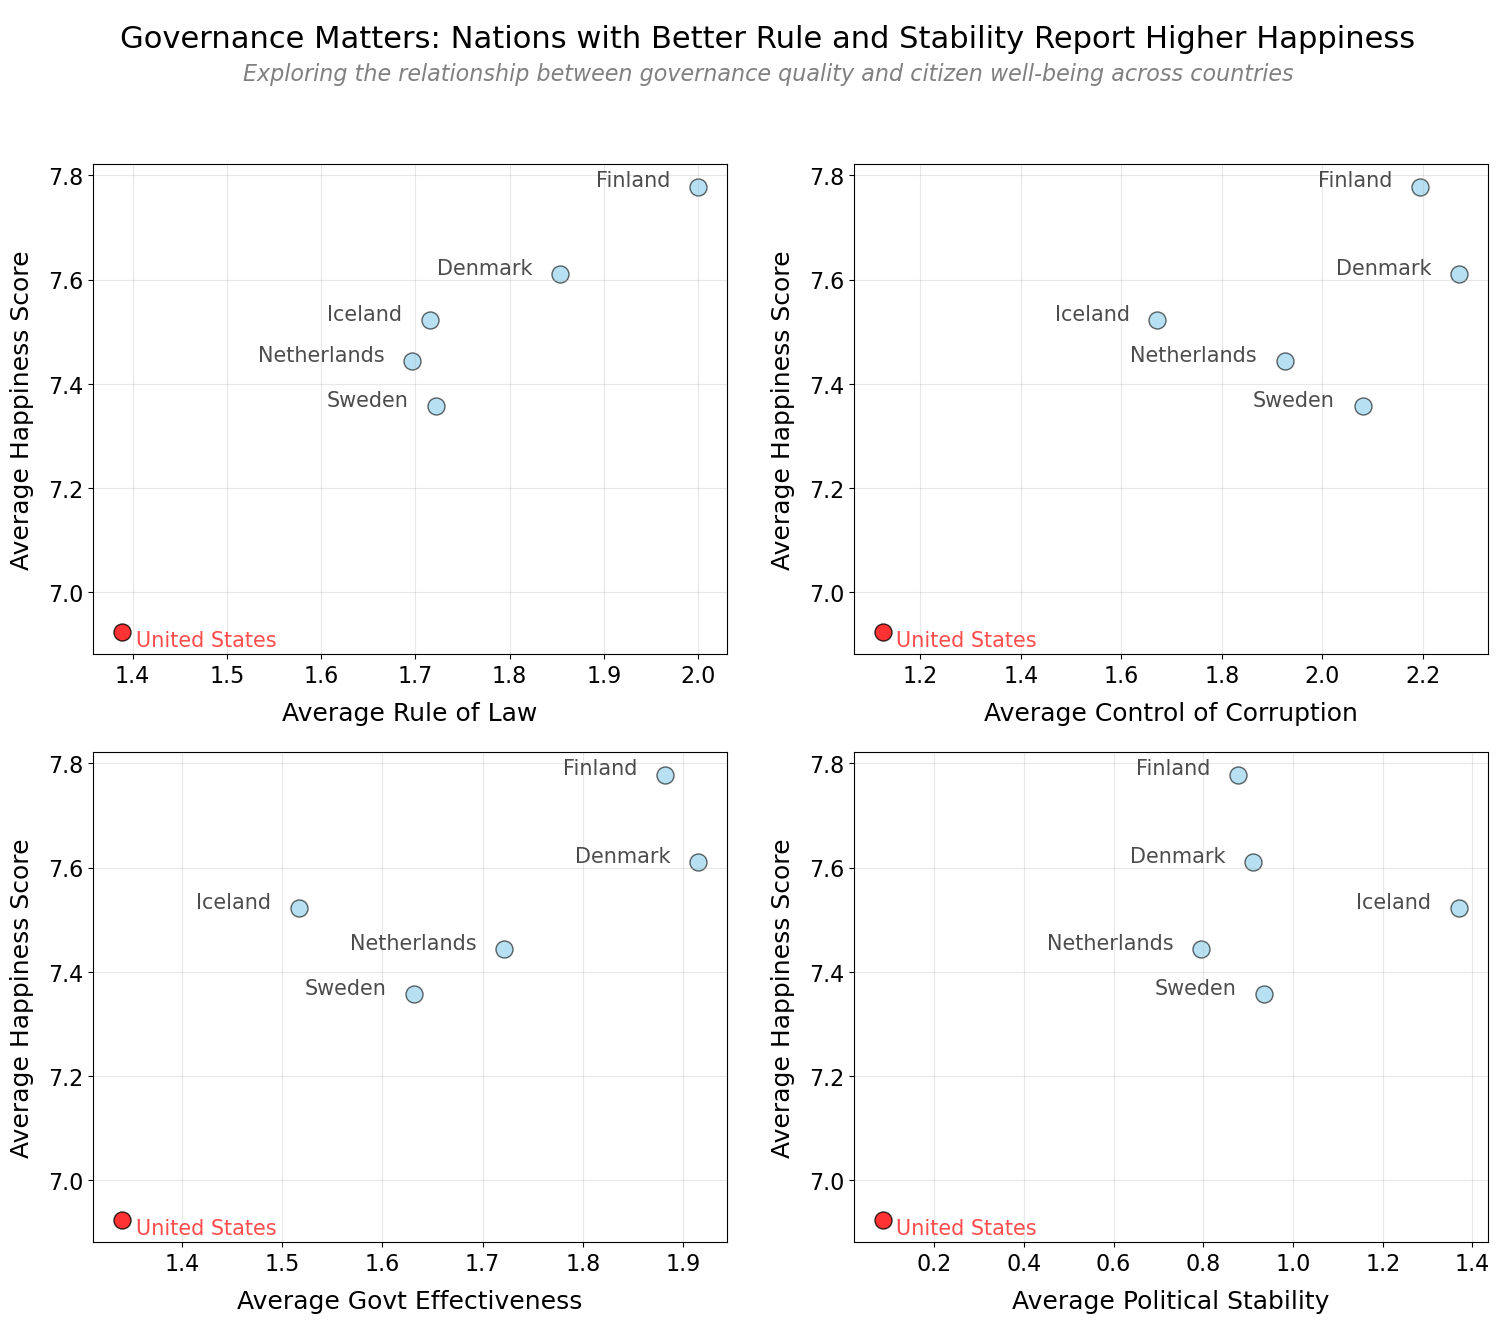

In [149]:
# Sets up the plot size, and axis to ensure the right format
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Iterated over each governance indicator and plot corresponding data using enumerate
for index, indicator in enumerate(indicators):
    ax = axes[index]
    
    # Plotted countries that are not the United States so they can match the same color and format
    non_us_df = df_avg[df_avg["Country"] != "United States"]
    # If its not the united states, then make the color of it skyblue
    ax.scatter(
        non_us_df[indicator], 
        # Plot the economic indicator that we have in the current loop at the moment
        # As well as the happiness score
        non_us_df["Happiness_Score"], 
        color='skyblue', 
        s=150,
        alpha=0.6, 
        edgecolor="k"
    )
    
    # I plotted the United States differently becuase I am comparing that to top 2024 happiest countries
    us_row = df_avg[df_avg["Country"] == "United States"]
    # Ensured this is inside the loop
    ax.scatter(
        us_row[indicator], 
        us_row["Happiness_Score"], 
        color='red', 
        s=150,
        alpha=0.8, 
        edgecolor="k"
    )
    
    # Annotated countries (including US) using list comprehension,
    # with different annotation for the US
    country_rows = [
        row for row in df_avg.itertuples(index=False) 
        if getattr(row, indicator) > 1.0 or row.Happiness_Score > 6.5
    ]
    
    # Annotated each qualifying country on the plot.
    # The U.S. label is positioned and colored differently for prominence.
    annotations = [
        ax.annotate(
            row.Country,
            (getattr(row, indicator), row.Happiness_Score),
            # Offset the text position differently for the US and other countries
            textcoords="offset points",
            # Aligned text differently to avoid overlap and improve readability
            xytext=(10, -10) if row.Country == "United States" else (-20, 0),
            # Colored the US label red for visibility, others use default color
            ha='left' if row.Country == "United States" else 'right',
            fontsize=15,
            color='red' if row.Country == "United States" else None,
            # Slight transparency for annotation text
            alpha=0.7
        )
        for row in country_rows  
        # Looped over all selected countries
    ]
    
    # Set descriptive axis labels and title with improved readability.
    # Changed the column name to have spaces instead of camel case
    # Used labelpad to space out axes
    ax.set_xlabel(f"Average {indicator.replace('_', ' ')}", fontsize=18, labelpad=10)
    ax.set_ylabel("Average Happiness Score", fontsize=18, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True, alpha=0.3)

# Add main title
plt.suptitle(
    "Governance Matters: Nations with Better Rule and Stability Report Higher Happiness",
    fontsize=22,
    y=0.98
)

# Added subtitle
plt.figtext(
    0.5, 0.94,
    "\n\nExploring the relationship between governance quality and citizen well-being across countries",
    ha='center',
    fontsize=16,
    style='italic',
    color='gray'
)

# Overall layout, title, and plot
plt.tight_layout(rect=[0, 5, 1, 0.88], h_pad=3.0, w_pad=2.0)
plt.savefig("/files/me204-2025-project-jayden/docs/figures/governance_vs_happiness.svg", format="svg", bbox_inches='tight')
plt.show()

### Note on Scatterplot Axis Scales*

To improve readability and highlight meaningful patterns, I adjusted the axis ranges in the scatterplots.

- For **Rule of Law**, **Control of Corruption**, and **Government Effectiveness**: I set the x-axis to range from **1.4 to 2.0**.
- On the y-axis, which represents **Average Happiness Score**: I limited the range to **6.8 to 7.8**. This allowed the picture to focus on countries with relatively high levels of happiness, which is the main comparison group relevant to the main question, and avoid visual clutter.

These axis limits were not chosen to exaggerate relationships, but rather to **avoid overlapping points** and improve the visual clarity of trends among the countries of interest, making the patterns and differences easier to interpret.

In addition to this, a “1-Point” Gap Is Bigger Than It Looks.
The governance indicator are standardized scores ranging from roughly -2.5 to +2.5. So when the U.S. scores around +1.2, and countries like Finland or Denmark score +2.2, that’s not just a small numerical gap, it’s a full standard deviation or more. That’s a major shift in governance quality.

### Scatterplot Analysis

Could weak governance be holding back U.S. happiness?

Looking at these four scatter plots, I found something pretty interesting about what actually makes countries happy. Even though the U.S. has one of the highest GDPs in the world, it consistently scores lower on happiness compared to countries like Finland, Denmark, and Sweden.
 
What really stood out was how these happy countries managed to achieve higher happiness scores despite not necessarily having higher economic output than the U.S. The key difference seemed to be in their governance quality, specifically how well their institutions function and how much citizens trust their government.

In almost all of the plots, the happiest countries all cluster in the upper right corner. They have both governance scores and high happiness. The U.S., marked in red, sits noticeably lower on both dimensions. This pattern repeated across all four governance indicators.
 
The Control of Corruption plot was particularly telling. The happiest countries all scored very high on corruption control, while the U.S. lagged behind. This suggests that people are happier when they feel their institutions are clean and trustworthy, regardless of how wealthy their country might be overall.

Government Effectiveness and Political Stability showed similar patterns. The U.S. consistently underperformed relative to its economic status, while smaller countries with strong institutions punched above their weight in terms of citizen wellbeing.

## Conclusion

So what does this all mean?

This analysis helps understand why the U.S. happiness gap exists. It seems as if it's not about money. It could moreso be about trust, fairness, and feeling like the system works for everyone. The happiest countries have figured out how to build institutions that people believe in, and that translates directly into higher life satisfaction.

The data showed me that governance quality might be more important for happiness than raw economic power. Countries can't just spend their way to citizen wellbeing, they need to build transparent, effective institutions that people actually trust.

In short, happy nations aren’t just rich. They’re well-governed, trusted, and stable. That might be the real foundation of national wellbeing.